In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import fftconvolve, convolve, unit_impulse
import IPython
import pyroomacoustics as pra
from pyroomacoustics.doa import circ_dist
from scipy import signal
from scipy.io.wavfile import write
import rir_generator as rir
import sounddevice as sd
from scipy import stats
import math

In [9]:
# Functions 
def keep_last(sig_arr, length, fs=44100):
    samples = int(fs*length)
    print(f'Samples: {samples}')
    sig_len = len(sig_arr[0])
    crop_start = sig_len - samples

    new_sig_arr = np.zeros((3, samples))
    i = 0
    for sig in sig_arr:
        new_sig_arr[i] = sig[crop_start:(crop_start+samples)]
        i += 1
    return new_sig_arr

def crop_audio(sig_arr, start, length, fs=44100):
    samples = int(fs*length)
    crop_start = int(fs*start)
    print(f'Crop start: {crop_start}')
    print(f'Samples: {samples}')

    new_sig_arr = np.zeros((3, samples))
    i = 0
    for sig in sig_arr:
        new_sig_arr[i] = sig[crop_start:(crop_start+samples)]
        i += 1
    return new_sig_arr

def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

In [16]:
# Source signal
audio_file="./SyncRecordings/new_clap_source.wav"
fs, source_signal = wavfile.read(audio_file)
snr_pwr = signaltonoise(source_signal)
snr_pwr

array(5.66313801e-05)

In [32]:
# Noise
distance = 2.2319
real_azimuth = 319 #From center of mic array

snr_db = 10*np.log10(snr_pwr)
sigma2 = 10**(-snr_db / 10) / (4. * np.pi * distance)**2
sample_rate = fs
print(f'SNR (dB) = {snr_db}')
print(f'Sigma 2 = {sigma2}')

SNR (dB) = -42.46942854278597
Sigma 2 = 22.447793669365836


Absorption = 0.31623097522674265
Max order = 54


Text(0.5, 0.92, '3D Ice lab')

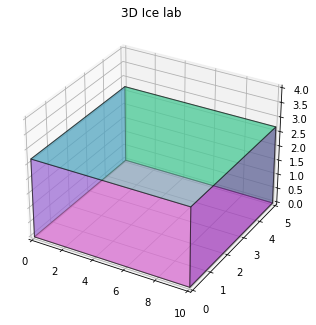

In [25]:
#  Reverberation and Setting up a room
rt60 = 0.38  # (From android RT app in lab)
room_dim = np.array([10., 5., 2.7])

e_absorption, max_order = pra.inverse_sabine(rt60, room_dim)

print(f'Absorption = {e_absorption}')
print(f'Max order = {max_order}')

room = pra.ShoeBox(room_dim, absorption=e_absorption, fs=sample_rate, max_order=max_order, sigma2_awgn=sigma2)


fig, ax = room.plot()
ax.set_xlim([0, 10])
ax.set_ylim([0, 5])
ax.set_zlim([0, 4])
ax.set_title("3D Ice lab")

Text(0.5, 0.92, '3D Ice lab with microphones')

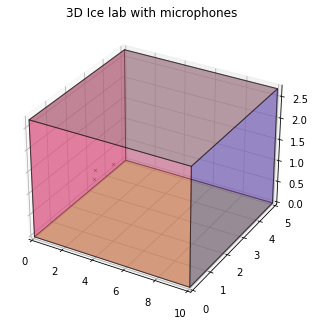

In [26]:
R = np.array([[1.029, 1.527, 1.559],[2.491, 2.019, 3.022], [0.762, 0.762, 0.762]]) #Real world lab setup
room.add_microphone_array(pra.MicrophoneArray(R, room.fs))
fig, ax = room.plot()
ax.set_title("3D Ice lab with microphones")

distance = 2.231870650373807
Source at: [3.3782 0.8636 0.8   ]


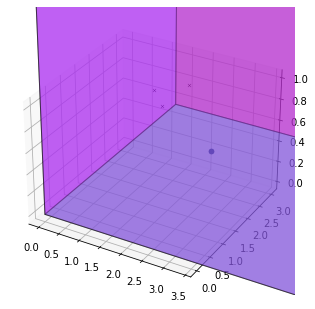

Simulating room...
room signals shape: (3, 5378228)
Done.


In [27]:
# Adding a source and running simulation

source_location = np.array([3.3782,0.8636, 0.8])

distance = np.sqrt((source_location[0]-R[0][1])**2 + (source_location[1]-R[1][1])**2 + (source_location[2]-R[2][1]**2))
print(f'distance = {distance}')

#Add a the source
room.add_source(source_location, signal=source_signal)
# room.add_source(source_location, signal=[0])
print(f'Source at: {source_location}')
fig, ax = room.plot()
plt.show()
# Run room simulation
print('Simulating room...')
room.simulate()
print(f'room signals shape: {room.mic_array.signals.shape}')
print('Done.')

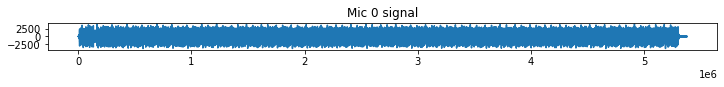

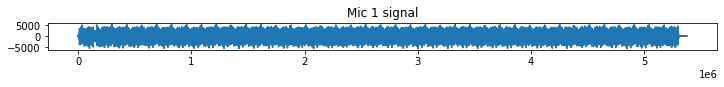

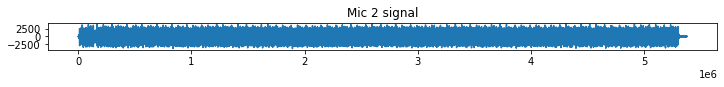

In [28]:
# Plot waveforms from each mic
for i in range(room.mic_array.signals.shape[0]):
    fig = plt.figure(figsize=(12, 0.5))
    ax = fig.add_subplot(111)
    ax.set_title(f'Mic {i} signal')
    ax.plot(room.mic_array.signals[i,:])
plt.show()
# Play 3 seconds of first mic recording
sd.play(room.mic_array.signals[1][:sample_rate*3])

Crop start: 3223709
Samples: 22050


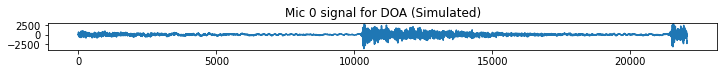

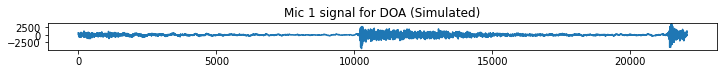

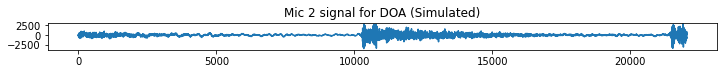

In [85]:
# Cropping signal for DOA
mic_array_signals = []

start = 73.1 # (seconds)
length = 0.5 # (seconds)
mic_array_signals = crop_audio(room.mic_array.signals, start, length)

for i in range(mic_array_signals.shape[0]):
    fig = plt.figure(figsize=(12, 0.5))
    ax = fig.add_subplot(111)
    ax.set_title(f'Mic {i} signal for DOA (Simulated)')
    ax.plot(mic_array_signals [i,:])
plt.show()

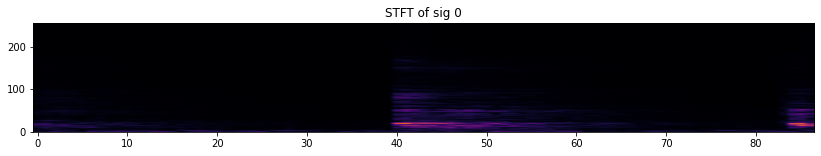

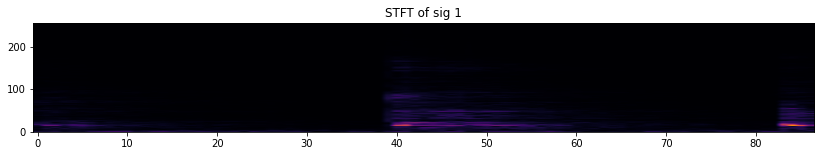

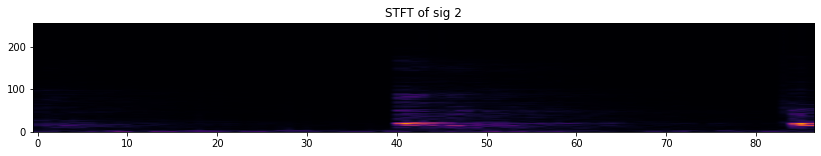

In [86]:
#Computing STFT's
nfft = 512
X = np.array([pra.transform.stft.analysis(sig, nfft, nfft // 2).T for sig in mic_array_signals])
i = 0
for x in X:
    fig = plt.figure(figsize=(14, 2))
    ax = fig.add_subplot(111)
    ax.imshow(np.absolute(x), cmap='inferno', origin='lower', aspect='auto')
    ax.set_title(f'STFT of sig {i}')
    i += 1

/home/pascal/.local/lib/python3.6/site-packages/pyroomacoustics/doa/plotters.py:344: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  antialiased=True, zorder=0)
No handles with labels found to put in legend.
SRP
/home/pascal/.local/lib/python3.6/site-packages/pyroomacoustics/doa/plotters.py:185: UserWarning: The plotly package is required to use this function
  warnings.warn('The plotly package is required to use this function')


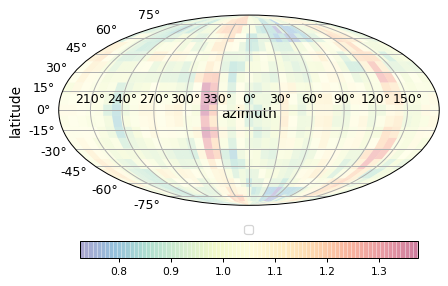

No handles with labels found to put in legend.
Real azimuth (deg): 319
Estimated azimuth (deg): 318.49382251703287
Estimated elevation (deg): 5.6815889505198065
MUSIC


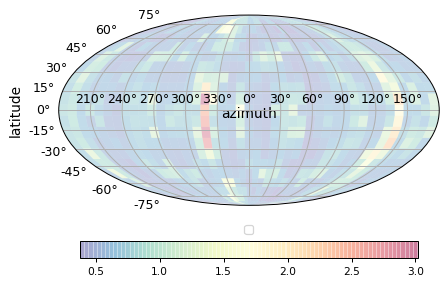

Real azimuth (deg): 319
Estimated azimuth (deg): 314.8758234237649
Estimated elevation (deg): -14.892126928211576
TOPS
No handles with labels found to put in legend.


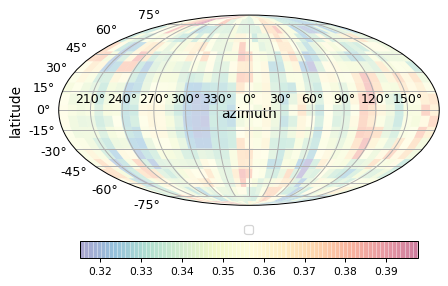

Real azimuth (deg): 319
Estimated azimuth (deg): 242.71746573760865
Estimated elevation (deg): -81.49385304652293
CSSM
No handles with labels found to put in legend.


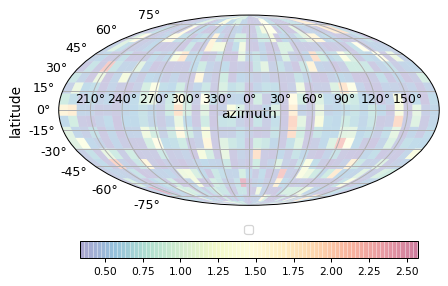

Real azimuth (deg): 319
Estimated azimuth (deg): 185.72208076570408
Estimated elevation (deg): 9.729682042820516


In [87]:
algo_names = ['SRP', 'MUSIC', 'TOPS', 'CSSM']
spatial_resp = dict()

c = 343
freq_range = [300, 1500]


for algo_name in algo_names:
    print(algo_name)
    doa = pra.doa.algorithms[algo_name](R, 
                  44100, 
                  nfft, 
                  c=c, 
                  num_src=1, 
                  dim=3, 
                  n_grid=1000)

    doa.locate_sources(X, freq_range=freq_range)

    # Find direction of maximum energy
    max_idx = doa.grid.find_peaks(k=1)[0]

    # Get maximum azimuth angle
    max_az = doa.grid.azimuth[max_idx]
    if max_az < 0:
        max_az += 2 * np.pi

    # Get maximum elevation angle
    max_el = doa.grid.colatitude[max_idx]
    max_el -= np.pi / 2
    doa.grid.plot()
    plt.show()
    
    print('Real azimuth (deg):', real_azimuth)
    print('Estimated azimuth (deg):', max_az * (180 / np.pi))
    print('Estimated elevation (deg):', max_el * (180 / np.pi))

# Real Audio

In [96]:
mic_1 = "./SyncRecordings/192.168.49.1_sync.wav"
mic_2 = "./SyncRecordings/192.168.49.200:38218_sync.wav"
mic_3 = "./SyncRecordings/192.168.49.201:55614_sync.wav"

# mic1_ns = "./SyncRecordings/192.168.49.1.wav"
# mic2_ns = "./SyncRecordings/192.168.49.200:38218.wav"
# mic3_ns = "./SyncRecordings/192.168.49.201:55614.wav"

fs, sig_1 = wavfile.read(mic_1)
fs, sig_2 = wavfile.read(mic_2)
fs, sig_3 = wavfile.read(mic_3)

# fs, sig1_ns = wavfile.read(mic1_ns)
# fs, sig2_ns = wavfile.read(mic2_ns)
# fs, sig3_ns = wavfile.read(mic3_ns)

# print(len(sig_1))

array_signals = np.zeros((3, len(sig_1)))
# array_sigs_ns = np.zeros((3, len(sig1_ns)))

array_signals[0] = sig_1
array_signals[1] = sig_2
array_signals[2] = sig_3

# array_sigs_ns[0] = sig1_ns
# array_sigs_ns[1] = sig2_ns
# array_sigs_ns[2] = sig3_ns


mic_array_sig = []
# mic_array_sig = keep_last(array_signals, 0.5)
start = 73.1 #(seconds)
length = 0.5 #(seconds)
mic_array_sig = crop_audio(array_signals, start, length)

# mic_array_sig_ns = crop_audio(array_sigs_ns, start, length)

Crop start: 3223709
Samples: 22050


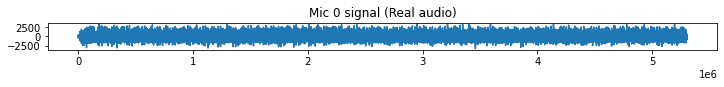

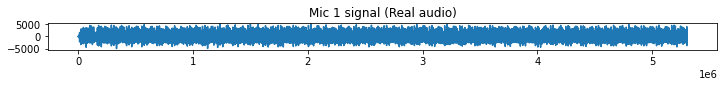

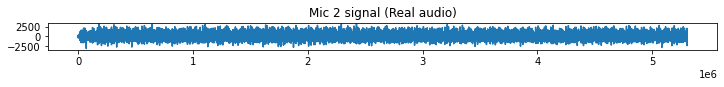

In [97]:
# Plot waveforms from each mic
for i in range(array_signals.shape[0]):
    fig = plt.figure(figsize=(12, 0.5))
    ax = fig.add_subplot(111)
    ax.set_title(f'Mic {i} signal (Real audio)')
    ax.plot(array_signals[i,:])
plt.show()
# Play 3 seconds of first mic recording
sd.play(array_signals[1][:sample_rate*3])

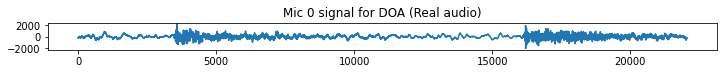

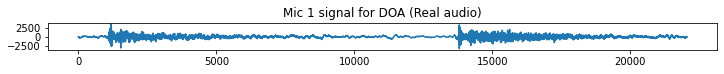

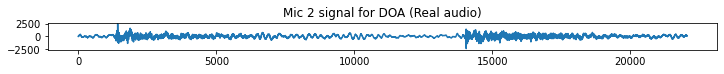

In [99]:
for i in range(mic_array_sig.shape[0]):
    fig = plt.figure(figsize=(12, 0.5))
    ax = fig.add_subplot(111)
    ax.set_title(f'Mic {i} signal for DOA (Real audio)')
    ax.plot(mic_array_sig[i,:])
plt.show()

# print('-------------------------------------------')
# for i in range(mic_array_sig_ns.shape[0]):
#     fig = plt.figure(figsize=(12, 0.5))
#     ax = fig.add_subplot(111)
#     ax.set_title(f'Mic {i} signal for DOA (Real audio non-synchronized)')
#     ax.plot(mic_array_sig_ns[i,:])
# plt.show()

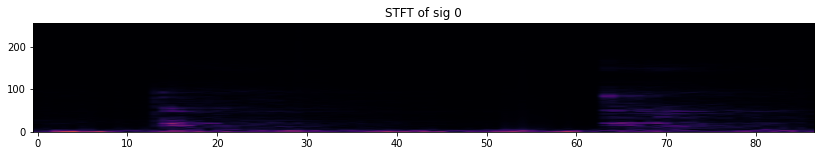

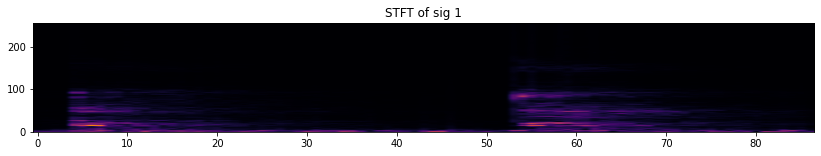

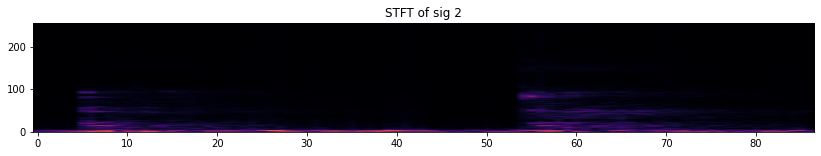

In [83]:
# Compute and plot STFT for all signals
X = np.array([pra.transform.stft.analysis(sig, nfft, nfft // 2).T for sig in mic_array_sig])

i = 0
for x in X:
    fig = plt.figure(figsize=(14, 2))
    ax = fig.add_subplot(111)
    ax.set_title(f'STFT of sig {i}')
    ax.imshow(np.absolute(x), cmap='inferno', origin='lower', aspect='auto')
    i+=1

SRP
/home/pascal/.local/lib/python3.6/site-packages/pyroomacoustics/doa/plotters.py:344: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  antialiased=True, zorder=0)
No handles with labels found to put in legend.
/home/pascal/.local/lib/python3.6/site-packages/pyroomacoustics/doa/plotters.py:185: UserWarning: The plotly package is required to use this function
  warnings.warn('The plotly package is required to use this function')


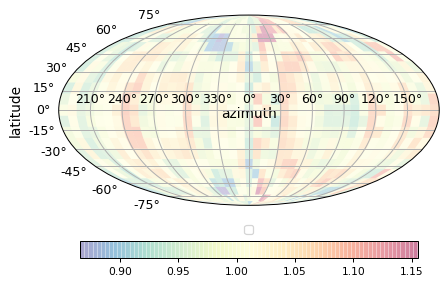

No handles with labels found to put in legend.
Real azimuth (deg): 319
Estimated azimuth (deg): 17.298207035558452
Estimated elevation (deg): -61.76322908282366
MUSIC


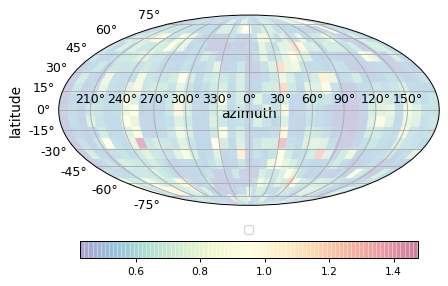

Real azimuth (deg): 319
Estimated azimuth (deg): 244.7903947611611
Estimated elevation (deg): 24.142031832344
TOPS
No handles with labels found to put in legend.


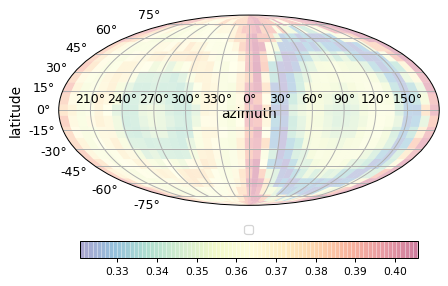

Real azimuth (deg): 319
Estimated azimuth (deg): 165.23292150113494
Estimated elevation (deg): 69.88429194550385
CSSM
No handles with labels found to put in legend.


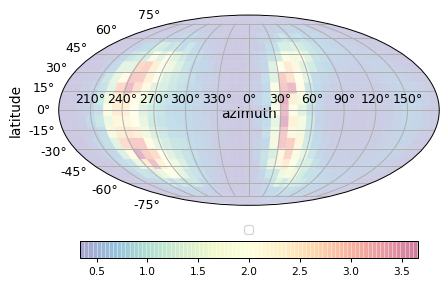

Real azimuth (deg): 319
Estimated azimuth (deg): 32.19725027289171
Estimated elevation (deg): -12.180961228392707


In [84]:
algo_names = ['SRP', 'MUSIC', 'TOPS', 'CSSM']
c = 343
freq_range = [300, 1500]


for algo_name in algo_names:
    print(algo_name)
    doa = pra.doa.algorithms[algo_name](R, 
                  44100, 
                  nfft, 
                  c=c, 
                  num_src=1, 
                  dim=3, 
                  n_grid=1000)

    doa.locate_sources(X, freq_range=freq_range)

    # Find direction of maximum energy
    max_idx = doa.grid.find_peaks(k=1)[0]

    # Get maximum azimuth angle
    max_az = doa.grid.azimuth[max_idx]
    if max_az < 0:
        max_az += 2 * np.pi

    # Get maximum elevation angle
    max_el = doa.grid.colatitude[max_idx]
    max_el -= np.pi / 2
    doa.grid.plot()
    plt.show()

    print('Real azimuth (deg):', real_azimuth)
    print('Estimated azimuth (deg):', max_az * (180 / np.pi))
    print('Estimated elevation (deg):', max_el * (180 / np.pi))